# Visuals

In [83]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data

In [27]:
df_turbines = pd.read_pickle(data_push_path / 'df_turbines_knn_blades_haversine_elevation_utc_2_2018_2023.pkl')
used_grid_points = df_turbines['nearest_grid_point'].unique()
grid_point_weights_dict = df_turbines['nearest_grid_point'].value_counts().to_dict()

In [4]:
ds = xr.open_dataset(data_path.joinpath('ERA5').joinpath('era5_combined_subset_derived_dropped_masked_2018_2023.nc'))

In [5]:
ds

<xarray.Dataset>
Dimensions:                    (time: 48168, latitude: 30, longitude: 37)
Coordinates:
  * longitude                  (longitude) float32 5.97 6.22 ... 14.72 14.97
  * latitude                   (latitude) float32 47.57 47.82 ... 54.57 54.82
  * time                       (time) datetime64[ns] 2018-01-01 ... 2023-06-3...
Data variables:
    t2m                        (time, latitude, longitude) float32 ...
    i10fg                      (time, latitude, longitude) float32 ...
    msl                        (time, latitude, longitude) float32 ...
    mean_wind_speed_10m        (time, latitude, longitude) float32 ...
    mean_wind_speed_100m       (time, latitude, longitude) float32 ...
    wind_direction_angle_10m   (time, latitude, longitude) float32 ...
    wind_direction_angle_100m  (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-09-11 11:36:09 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
# Lats and lons
lats = ds.latitude.values
lons = ds.longitude.values

In [9]:
lats

array([47.57, 47.82, 48.07, 48.32, 48.57, 48.82, 49.07, 49.32, 49.57,
       49.82, 50.07, 50.32, 50.57, 50.82, 51.07, 51.32, 51.57, 51.82,
       52.07, 52.32, 52.57, 52.82, 53.07, 53.32, 53.57, 53.82, 54.07,
       54.32, 54.57, 54.82], dtype=float32)

In [10]:
# Create a meshgrid for lat and lon values
lons, lats = np.meshgrid(lons, lats)

In [12]:
lats.shape

(30, 37)

### Plot grid points

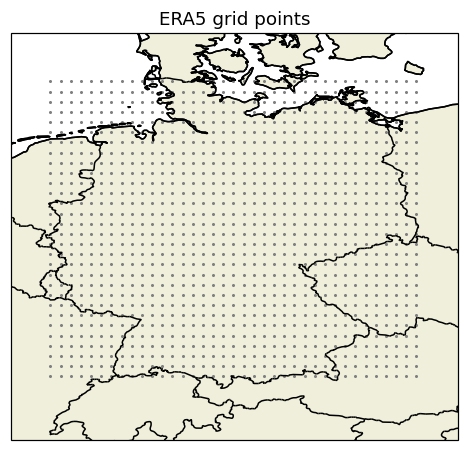

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# Frames Germany in the middle
ax.set_extent([5, 16, 46, 56])

# Plot the grid points
ax.scatter(lons, lats, color='grey', s=1, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title('ERA5 grid points')

plt.show()

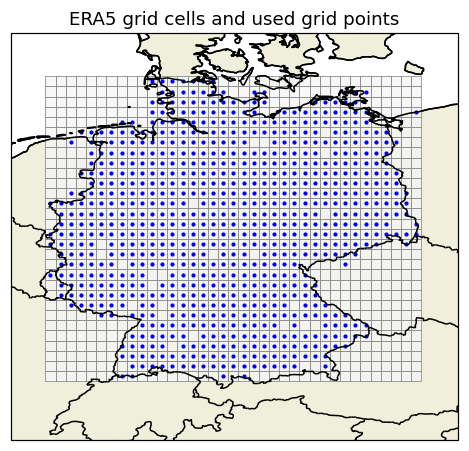

In [26]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])

grid_width = np.mean(np.diff(lons[0,:]))
grid_height = np.mean(np.diff(lats[:,0]))


# Draw the grid cells centered on each grid point
for i in range(lons.shape[0]):
    for j in range(lons.shape[1]):
        # Compute the bottom-left corner of the cell
        lower_left_x = lons[i, j] - grid_width / 2
        lower_left_y = lats[i, j] - grid_height / 2
        rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
                                  facecolor='whitesmoke', alpha=0.8, edgecolor='grey', linewidth=0.6, transform=ccrs.PlateCarree())
        ax.add_patch(rect)
        
        
# Plot the grid points
# ax.scatter(lons, lats, color='grey', s=0.5, transform=ccrs.PlateCarree())


# Find the closest grid center for each point in used_grid_points and plot it
for point in used_grid_points:
    # Find the index of the nearest latitude
    idx_lat = np.abs(lats[:, 0] - point[0]).argmin()
    
    # Find the index of the nearest longitude
    idx_lon = np.abs(lons[0, :] - point[1]).argmin()

    # Plot at the grid center
    ax.scatter(lons[idx_lat, idx_lon], lats[idx_lat, idx_lon], color='blue', s=3, transform=ccrs.PlateCarree())
    
    
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title('ERA5 grid cells and used grid points')

# ax.legend(loc='upper right')

plt.show()

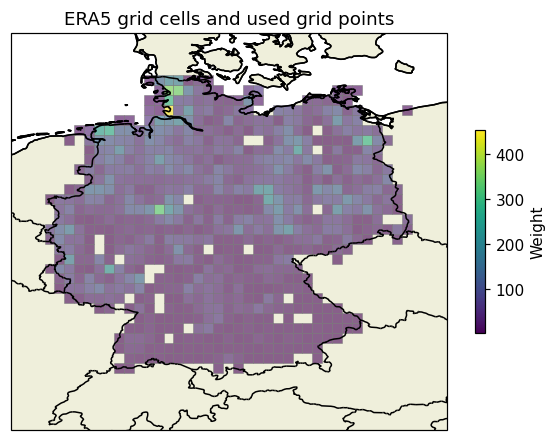

In [81]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])

grid_width = np.mean(np.diff(lons[0,:]))
grid_height = np.mean(np.diff(lats[:,0]))

# Min and max weight values for normalisation
min_weight = min(grid_point_weights_dict.values())
max_weight = max(grid_point_weights_dict.values())

for i in range(lons.shape[0]):
    for j in range(lons.shape[1]):
        # Get the weight for the current grid point
        weight = grid_point_weights_dict.get((lats[i, j], lons[i, j]), 0)
        
        # If weight is 0, skip drawing the cell
        if weight == 0:
            continue
        
        # Normalize the weight value to be between 0 and 1
        normalised_weight = (weight - min_weight) / (max_weight - min_weight)
        
        # Get the color corresponding to the weight from the colormap
        colour = plt.cm.viridis(normalised_weight)
        
        # Compute the bottom-left corner of the cell
        lower_left_x = lons[i, j] - grid_width / 2
        lower_left_y = lats[i, j] - grid_height / 2
        
        rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
                                  facecolor=colour, alpha=0.6, edgecolor='grey', linewidth=0.6, transform=ccrs.PlateCarree())
        ax.add_patch(rect)
        

# Create a fake image with the colormap and add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm._A = []  # This line is needed for the ScalarMappable to work
cb = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cb.set_label('Weight')

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title('ERA5 grid cells and used grid points')

plt.show()

### Emphasising lower weights using LogNorm in colour map using inverse transformation

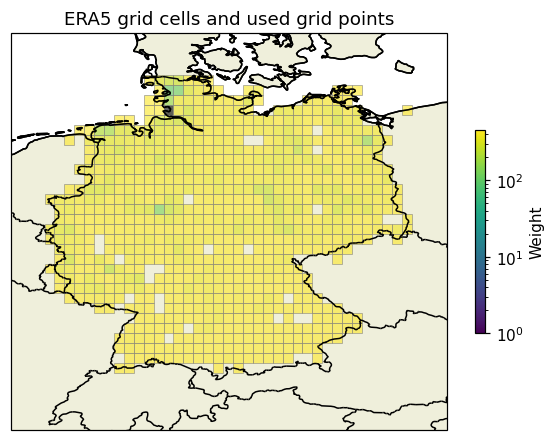

In [85]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])

grid_width = np.mean(np.diff(lons[0,:]))
grid_height = np.mean(np.diff(lats[:,0]))

# Min and max weight values for normalisation
min_weight = min(grid_point_weights_dict.values())
max_weight = max(grid_point_weights_dict.values())

# To avoid logarithm of zero, add a small value to weights
offset = 1e-10

for i in range(lons.shape[0]):
    for j in range(lons.shape[1]):
        # Get the weight for the current grid point
        weight = grid_point_weights_dict.get((lats[i, j], lons[i, j]), 0)
        
        # If weight is 0, skip drawing the cell
        if weight == 0:
            continue
            
            
        # Apply inverse transformation to emphasize low values
        transformed_weight = (max_weight - min_weight) - weight + min_weight
        # Normalize the transformed weight logarithmically
        norm = LogNorm(vmin=min_weight + offset, vmax=max_weight)(transformed_weight)
        
        
        # Get the color corresponding to the weight from the colormap
        colour = plt.cm.viridis(norm)
        
        # Compute the bottom-left corner of the cell
        lower_left_x = lons[i, j] - grid_width / 2
        lower_left_y = lats[i, j] - grid_height / 2
        
        rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
                                  facecolor=colour, alpha=0.6, edgecolor='grey', linewidth=0.6, transform=ccrs.PlateCarree())
        ax.add_patch(rect)
        

# Create a fake image with the colormap and add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=min_weight + offset, vmax=max_weight))
sm._A = []  # This line is needed for the ScalarMappable to work
cb = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cb.set_label('Weight')

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title('ERA5 grid cells and used grid points')

plt.show()

### Showing better separation of lower weights! More what I want 

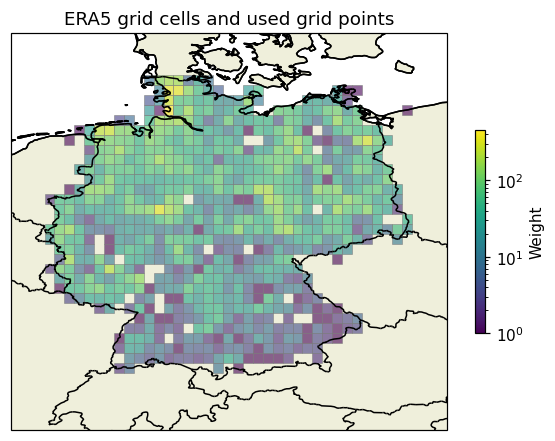

In [86]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([5, 16, 46, 56])

grid_width = np.mean(np.diff(lons[0,:]))
grid_height = np.mean(np.diff(lats[:,0]))

# Min and max weight values for normalisation
min_weight = min(grid_point_weights_dict.values())
max_weight = max(grid_point_weights_dict.values())

# To avoid logarithm of zero, add a small value to weights
offset = 1e-10

for i in range(lons.shape[0]):
    for j in range(lons.shape[1]):
        # Get the weight for the current grid point
        weight = grid_point_weights_dict.get((lats[i, j], lons[i, j]), 0)
        
        # If weight is 0, skip drawing the cell
        if weight == 0:
            continue
            
            
        # Normalize the weight logarithmically
        norm = LogNorm(vmin=min_weight + offset, vmax=max_weight)(weight)
        
        
        # Get the color corresponding to the weight from the colormap
        colour = plt.cm.viridis(norm)
        
        # Compute the bottom-left corner of the cell
        lower_left_x = lons[i, j] - grid_width / 2
        lower_left_y = lats[i, j] - grid_height / 2
        
        rect = mpatches.Rectangle((lower_left_x, lower_left_y), grid_width, grid_height,
                                  facecolor=colour, alpha=0.6, edgecolor='grey', linewidth=0.6, transform=ccrs.PlateCarree())
        ax.add_patch(rect)
        

# Create a fake image with the colormap and add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='viridis', norm=LogNorm(vmin=min_weight + offset, vmax=max_weight))
sm._A = []  # This line is needed for the ScalarMappable to work
cb = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cb.set_label('Weight')

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.set_title('ERA5 grid cells and used grid points')

plt.show()